In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import sympy as sym
import scipy
from tqdm import tqdm # For clean progress bars

import matplotlib.animation as animation
from IPython.display import HTML # To animate the histogram changes
import ipywidgets as widgets
import datetime
%matplotlib inline
# For interactive graphs

In [2]:
def newton_raphson_solver(f, x_0, max_iterations = 100, dx = 1e-3, return_error=False, tolerance = 1e-2, debug_mode=False):
    # Returns a zero of f given initial condition (x_0,f(x_0)). Modified from standard techniques to fail more gracefully in certain edge cases.
    x_n = x_0
    for i in range(max_iterations):
        f_prime_n = (f(x_n+dx)-f(x_n))/dx
        if f_prime_n == 0:
            raise ZeroDivisionError
        x_n = x_n - f(x_n)/f_prime_n
        if debug_mode: print(f(x_n))
    return_error = np.abs(f(x_n)) > tolerance 
    if return_error:
        raise ValueError(x_n, f(x_n))
    return x_n

newton_raphson_solver(lambda x: np.cos(x)-x, 0) # Should yield about 0.739 if all works correctly

0.7390851332151607

$F_{\max}\Delta t/\gamma = \sqrt{2D\Delta t}$

$\frac{F_{\max}\Delta t \cdot D_b}{k_BT_b} = \sqrt{2D_bT_{\max}\Delta t/T_b}$

$\frac{D_bF_{\max}^2\Delta t}{2k_B^2T_b}=T_{\max}$

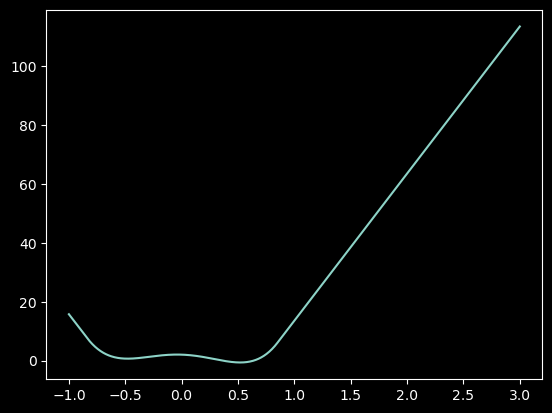

In [3]:
# DEFINITIONS

k_B = 1 # Special units
T_b = 1 # Special units


x_well = 0.5 # Special units
E_barrier = 2*k_B*T_b # J
E_tilt = 1.3*k_B*T_b # J
F_max = 50 # Special Units

F_left = 1.0*F_max
F_right = 1.0*F_max

# asymmetry = 1 # |x_max/x_min|
x_min = -2*x_well # Always negative by convention.
x_max = 3*(-x_min) #np.abs(asymmetry*x_min)


D = 170 # px^2/s
gamma = k_B*T_b/D #0.02

char_time = (x_max-x_min)*gamma/F_max # s (hopefully): Time required to cover the entire domain moving at the maximum velocity, F_max/gamma
expt_length = 0.1 # s
dt = 1e-5 # s

def U_0(x):
    return E_barrier*(1-2*(x/x_well)**2 + (x/x_well)**4) - E_tilt*(x/x_well)/2
def dU_0dx(x):
    return E_barrier*(-4*x/x_well**2 + 4*x**3/x_well**4) - E_tilt/(2*x_well)

# E_strength = 1*k_B*T_b
n = 1
x_s = 2.0
E_shelf = 5*k_B*T_b
def U_w0(E_0, x):
    return E_0*(x/x_well)**(2*n+1) + E_shelf*(x/x_well)
def dU_w0dx(E_0, x):
    return (2*n+1)*(E_0/x_well)*(x/x_well)**(2*n) + E_shelf/x_well

W = False
B = False and not W
test_mode = False and not (B or W)
flat = False and not (test_mode or B or W)

try:
    x_l = newton_raphson_solver(lambda x: dU_0dx(x) + F_max, x_min, dx=1e-6)
    x_r = newton_raphson_solver(lambda x: dU_0dx(x) - F_max, x_max, dx=1e-6)
    # x_d = newton_raphson_solver(lambda x: dU_bdx(x) + F_max, x_max, dx=1e-6)
    # x_d = newton_raphson_solver(lambda x: dU_bdx(x) + F_left, x_max, dx=1e-6)
    if B:
        x_d = -(x_well**2)*F_max/(2*E_strength)
        x_s = -(x_well**2)*F_left/(2*E_strength)
        # E_strength = newton_raphson_solver(lambda E: dU_b0dx(E, -x_s)-F_max, x_0=energy_ratio)
    if W:
        E_strength = newton_raphson_solver(lambda E: dU_w0dx(E, -x_s)-F_max, x_0=E_shelf)
        U_w = lambda x: U_w0(E_strength, x)
        x_d = newton_raphson_solver(lambda x: dU_w0dx(E_strength, x)-F_right, x_0=x_s)

    def U_b(x):
        return -E_strength*(x/x_well)**2

    y = sym.symbols("y")
    dU_0dx = sym.lambdify(y, sym.diff(U_0(y), y))
    if W: dU_wdx = sym.lambdify(y, sym.diff(U_w(y), y))
    if B: dU_bdx = sym.lambdify(y, sym.diff(U_b(y), y))

except ZeroDivisionError:
     print("Zero slope potential; setting x_l=x_min and x_r=x_max")
     x_l = x_min
     x_r = x_max # Makes it so that the code still works for flat potentials. This is a possible source of error if the code has a lot of opints of inflection: check that x_min and x_max are not maxima/minima.


def U(x, x_l=x_l, x_r=x_r, W=W, B=B, test_mode = test_mode):
#     if x > x_l and x < x_r:
#         return U_0(x)
#     else:
#         if x < x_l:
#             return U_0(x)-F_max*x
#         else:
#             return U_0(x)+F_max*x
    in_well = (x >= x_l) & (x <= x_r)
    left_of_well = (x < x_l)
    right_of_well = (x > x_r)
    # Boolean arrays to determine where the particle is relative to the 'walls'
    if B:
        return U_0(x)*in_well + (U_0(x_r) + F_left*(x-x_l))*left_of_well + (U_0(x_r) - U_b(-x_d) + U_b(x-x_r-x_d))*(right_of_well & (x < x_r+x_d-x_s)) + (U_0(x_r) - U_b(-x_d) + U_b(-x_s) + F_right*(x-x_d-x_s-x_r))*(x >= x_r+x_d+x_s)
    if W:
        return U_0(x)*in_well + (U_0(x_l) - F_left*(x-x_l))*left_of_well + (U_0(x_r) - U_w(-x_s) + U_w(x-x_r-x_s))*(right_of_well & (x < x_r+x_s+x_d)) + (U_0(x_r) - U_w(-x_s) + U_w(x_d) + F_right*(x-x_r-x_s-x_d))*(x >= x_r+x_d+x_s)
    if test_mode:
        return E_barrier*(x/x_well)**2
    if flat:
        if type(x) == float:
            return 0
        return np.zeros(x.shape)
    return U_0(x)*in_well + (U_0(x_l)-F_left*(x-x_l))*left_of_well + (U_0(x_r)+F_right*(x-x_r))*right_of_well

def F(x, x_l = x_l, x_r = x_r, W=W, B=B, test_mode=test_mode):
#     if x > x_min and x < x_max:
#         return -dU_0dx(x)
#     else:
#         if x > x_max:
#             return -F_max
#         else:
#             return F_max 
    in_well = (x >= x_l) & (x <= x_r)
    left_of_well = (x < x_l)
    right_of_well = (x > x_r)
    if B:
        return -dU_0dx(x)*in_well - F_right*right_of_well - dU_bdx(x-x_l-x_d)*(left_of_well & (x > x_l+x_d-x_s)) + F_left*(x <= x_l+x_d-x_s)
    if W:
        return -dU_0dx(x)*in_well + F_left*left_of_well - dU_wdx(x-x_r-x_s)*(right_of_well & (x < x_r+x_s+x_d)) - F_right*(x >= x_r+x_d+x_s)
    if test_mode:
        return -2*E_barrier*(x/x_well**2)
    if flat:
        if type(x) == float:
            return 0
        return np.zeros(x.shape)
    return -dU_0dx(x)*((x > x_l) & (x < x_r)) + F_left*(x<=x_l) - F_right*(x>=x_r)

unnormalised_boltzmann = lambda x, T: np.exp(-U(x)/(k_B*T))

test_range = np.linspace(x_min, x_max, 1000)

plt.close()
plt.plot(test_range, U(test_range)) # This should be continuous
# plt.scatter([x_l, x_r, x_r+x_s+x_d], [U(x_l), U(x_r), U(x_r+x_s+x_d)])
# plt.plot(test_range, U(test_range), 'r')
plt.show()

In [4]:
p_unnormalised = lambda x, T: np.exp(-U(x, x_l=x_l, x_r=x_r)/(k_B*T))
Z = lambda T: scipy.integrate.quad_vec(lambda x: p_unnormalised(x, T), x_min, x_max)[0]
p = lambda x, T: p_unnormalised(x, T)/Z(T)
dpdx = lambda x, T: p(x,T)*F(x, x_l=x_l, x_r=x_r)/(k_B*T)

x_barrier = newton_raphson_solver(lambda x: F(x, x_l=x_l, x_r=x_r), x_0=0) # This is equivalent to setting dpdx=0. Note that this may cause the function to find the maxima of the pdf instead of the minima, but this is quite unlikely
print(x_barrier)

p_left = lambda T: scipy.integrate.quad_vec(lambda x: p(x, T), x_min, x_barrier)[0]
p_right = lambda T: scipy.integrate.quad_vec(lambda x: p(x, T), x_barrier, x_max)[0]
p_right_1 = lambda alpha: scipy.integrate.quad_vec(lambda x: p(x, 1000), x_barrier, -alpha*x_min)[0]

-0.04089864450711718


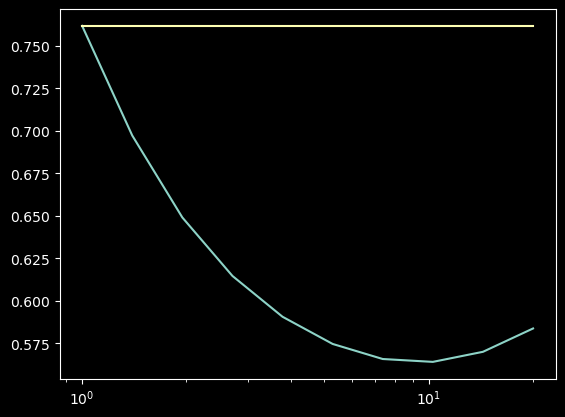

In [5]:
plt.close()
temps = np.logspace(0, np.log(20)/np.log(10), 10)
alphas = np.logspace(0, np.log(9)/np.log(10), 10)

# p_left(temps)
p_1 = p_right(1)
arr = []
# for alpha in alphas:
#     arr.append(p_right_1(alpha))
# plt.semilogx(alphas, arr)
plt.semilogx(temps, p_right(temps))
plt.semilogx(temps, p_1*np.ones(temps.shape))
plt.show()

In [6]:
# newton_raphson_solver(lambda T: p_right(T)-p_1, 40, max_iterations=3)
# p_right(4.9547)-p_right(1)

In [7]:
# LANGEVIN SIMULATION
def outside_domain(x, x_min=x_min, x_max=x_max):
    return (x < x_min) | (x > x_max)

def langevin_simulation(x_0, dt=dt, expt_length = expt_length, force = F, temperature_function=lambda t: T_b, infinite_wall = False):
    timesteps = round(expt_length/dt)
    # times = np.linspace(0, expt_length, timesteps)
    # ridiculously_high_force = F_max*100
    # if infinite_wall:
    #     new_force = lambda x: force(x)*(~outside_domain(x)) - ridiculously_high_force*(x > x_max) + ridiculously_high_force*(x < x_min)
    # else:
    new_force=force
    x = [x_0]
    x_n = x_0
    t = np.arange(0,expt_length, dt)
    D = temperature_function(t)*k_B/gamma
    thermal_fluctuation_std = np.sqrt(2*D*dt)
    stochastic_displacement = np.random.normal(0,thermal_fluctuation_std, size=(*x_0.shape, timesteps))
    
    for i in tqdm(range(timesteps)):
        deterministic_displacement = new_force(x_n)*dt/gamma
        # if infinite_wall:
        #     new_x = stochastic_displacement[:,i] + deterministic_displacement + x_n
        #     escaped = outside_domain(new_x, x_min=x_min, x_max=x_max)
        #     stochastic_displacement[:,i] *= ~escaped
        #     stochastic_displacement[:,i] += (new_x > x_max)*(x_max-stochastic_displacement[:,i])
        #     stochastic_displacement[:,i] += (new_x < x_min)*(x_max-stochastic_displacement[:,i])
        x_n = x_n + (deterministic_displacement + stochastic_displacement[:, i])#*((~outside_domain(x_n)) | (~infinite_wall)) + (x_min-x_n)*(x_n < x_min) + (x_max-x_n)*(x_n > x_max)
        # For the moment, no measurement noises are assumed.
        if infinite_wall:
            x_n = x_n*(~outside_domain(x_n)) + (x_n > x_max)*(x_max-(x_n % x_max)) + (x_n < x_min)*(x_min-(x_n % x_min))
            """ 
            If there is an infinite wall, we have the wall behave like a mirror if the particle leaves the domain: if the particle is at a distance p+x_max away from x_max, we adjust the position of the particle so it is now at x_max-p. Note that this requires ~8N extra operations to be performed and thus slows down the code.

            However, we must proceed with caution! If p > (x_max-x_min), x_max-p < x_min, which means that the particle will have left the box! The probability of this occuring for alpha = 1 is low at T_h = 1000. (A heuristic that can be used to evaluate the probability of this happening is to evaluate the standard deviation sigma of the particle at the maximum temperature and compare 4*sigma to |x_max-x_min|. If |x_max-x_min| > 4*sigma, on average one particle out of 10,000 will escape the domain like this. For T_h=1000, dt = 1.59e-5, sigma = sqrt(2*k_BT_h*dt/gamma) = 0.39, and 4*sigma ~= 1.59 < |x_max-x_min|=2 at alpha=1. This suggests that there is a negligible probability that this phenomenon will occur. However, if T_h > 1577, this phenomenon may occur with nontrivial probability for alpha=1.) If the particle *does* leave the box, the simulation will become unreliable: the particle will leave the box and move around a little before the program realises that the particle is not supposed to be outside the box and moves it back inside -- it will have reflected incorrectly.

            The fix for this will likely be to define a function that repeatedly checks whether the particle is in the domain and applies the reflection accordingly until all particles are within the domain. Another way is to calculate p % |x_max-x_min| and decide where to put the particle based on this value. 

            Testing this code for 10,000 particles with an initial temperature = 10,000 has yielded no escape behaviour.
            """
        x.append(x_n)
    return x

# DISTANCE FUNCTIONS

def L1(vec1, vec2, axis=None):
    assert len(vec1) == len(vec2), f"Mismatch between vec1 {np.array(vec1).shape} and vec2 {np.array(vec2).shape}"
    return np.sum(np.abs(vec2-vec1), axis=axis)

def helper(element):
    # Avoids issues with taking the log of 0.
    if element == 0:
        return 0
    else:
        return np.log(element)
log_ish = np.vectorize(helper)

def kullback_leibler(vec1, vec2):    
    assert len(vec1) == len(vec2)
    return np.sum(vec1*log_ish(vec1) - vec1*log_ish(vec2))


In [8]:
# UNCOMMENT TO USE CUSTOM SAMPLING CODE

# Z_T = lambda T: scipy.integrate.quad_vec(lambda x: unnormalised_boltzmann(x, T), x_min, x_max)[0]
# def boltzmann(x, T=100):
#     return unnormalised_boltzmann(x, T)/Z_T(T)
# def inverse_sample_decorator(dist):
    
#     def wrapper(pnts, x_min=x_min, x_max=x_max, n=1e5, **kwargs):
        
#         x = np.linspace(x_min, x_max, int(n))
#         cumulative = np.cumsum(dist(x, **kwargs))
#         cumulative -= cumulative.min()
#         f = scipy.interpolate.interp1d(cumulative/cumulative.max(), x)
#         return f(np.random.random(pnts))
    
#     return wrapper
# @inverse_sample_decorator
# def boltzmann_samples(x, T=100):
#     return unnormalised_boltzmann(x, T)/Z_T(T)

# samples = boltzmann_samples(10_000, T=1)
# plt.hist(samples, bins = 100)[2]

In [9]:
# def CDF(p, x, dx = (x_max-x_min)/1000):
#     return np.sum(p(np.arange(x_min, x, dx))*dx)
# Z = lambda T: scipy.integrate.quad_vec(lambda x: unnormalised_boltzmann(x, T), x_min, x_max)[0]
# boltzmann = lambda x, T: unnormalised_boltzmann(x, T)/Z(T)

# test_range = np.linspace(x_min, x_max, 1000)
# outs = [CDF(p = lambda x: boltzmann(x, 10), x=x) for x in test_range]

# plt.plot(test_range, outs)
# plt.plot(test_range, boltzmann(test_range, 10))

In [11]:
plt.close()
keys = ['h','w','c','f']
temperature = {}
# Ensemble
temperature['h'] = T_b * 1000
temperature['w'] = T_b * 12
temperature['c'] = T_b * 1
# temperature['f'] = T_b * 1e-1 # "Frozen" -- can this 'heat' up?

active_range = np.linspace(x_min, x_max, 100_000)
N = 10_000
tau = 0*dt
times = np.arange(0, expt_length, dt)

unnormalised_distro = {T: unnormalised_boltzmann(active_range, temperature[T]) for T in temperature}
Z = {T: scipy.integrate.quad(lambda x: unnormalised_boltzmann(x, temperature[T]), x_min, x_max)[0] for T in temperature}
normalised_distro = {T: unnormalised_distro[T]/Z[T] for T in temperature}
initial_distro = {T: unnormalised_distro[T]/np.sum(unnormalised_distro[T]) for T in temperature}
results = {T: [] for T in temperature}

def exponential_decay(t, tau, T='h', T_b=T_b):
    if tau == 0:
        if type(t) == np.ndarray: return T_b*np.ones(t.shape)
        return T_b
    return (temperature[T]-T_b)*np.exp(-t/tau) + T_b

def initial_position(x_range, num_particles, p):
    return np.random.choice(x_range, num_particles, p=p)

def export(figure, parent_directory, prefixes = "", params = {"E_b" : E_barrier, "E_tilt" : E_tilt, "E_shelf" : E_shelf, "x_min" : x_min, "x_max" : x_max, "x_well" : x_well, "x_s" : x_s, "D" : D, "T_h": temperature['h'], "T_w": temperature['w'], "tau": tau}):
    # Helper function to export parameter list as well as figures.
    filename = parent_directory +r"/"+prefixes + datetime.datetime.now().isoformat()[:-10].replace(":", "_")
    with open(filename+"_parameters.txt", 'w') as file:
        for key in params:
            file.write(f"{key}: {params[key]}\n")
    file.close()
    figure.savefig(filename+".png")
    return 0

# for trial in tqdm(range(N)):
for T in temperature:
    # x = np.zeros(N) # Delta function initial condition (for diffusion test)
    x = initial_position(active_range, N, p=initial_distro[T])
    # x = boltzmann_samples(N, T=temperature[T])
    temperature_function = lambda t: exponential_decay(t, tau, T=T)
    results[T] = np.array(langevin_simulation(x, temperature_function=temperature_function)).T
    # plt.loglog(temperature_function(times))
plt.show()

100%|██████████| 10000/10000 [00:03<00:00, 2690.50it/s]


In [9]:
plt.close()
if tau != 0:
    temperature_function= lambda t: (temperature['h']-T_b)*np.exp(-t/tau)+T_b

    plt.loglog(times, temperature_function(times))
plt.show()

# langevin_simulation(np.array([0]), temperature_function = lambda t: exponential_decay(t, 100*dt, T='h'), infinite_wall=True)

In [11]:
BINS = 100

binned_active_domain = np.linspace(x_min, x_max, BINS)

global_min = np.min(results['h'])
global_max = np.max(results['h'])
inefficiencies = (global_max/x_max, global_min/x_min)
print(f"Inefficiency = {inefficiencies}")
inefficiency = (global_max-global_min)/(x_max-x_min)

if inefficiency > 1:
    binned_active_range0 = np.linspace(global_min, global_max, round(BINS*inefficiency)-1)
else:
    binned_active_range0 = np.linspace(global_min, global_max, BINS-1)

dx = binned_active_range0[1]-binned_active_range0[0]
binned_active_range0 += dx/2 # We must calculate distributions from the *centres* of the bins, not the edges!
binned_active_range = np.insert(binned_active_range0, 0, binned_active_range0[0]-dx)


if not (inefficiency > 100):
    unnormalised_distro_init = {T: unnormalised_boltzmann(binned_active_range, temperature[T]) for T in temperature}
    binned_initial_distro = {T: unnormalised_distro_init[T]/np.sum(unnormalised_distro_init[T]) for T in temperature}

    unnormalised_distro_fin = unnormalised_boltzmann(binned_active_range, T_b)
    binned_final_distro = unnormalised_distro_fin/np.sum(unnormalised_distro_fin)

    heights_init, bins_init = {}, {}
    heights_fin, bins_fin = {}, {}
    heights_mid, bins_mid = {}, {}
    heights_mid2 = {}

    for T in temperature:
        heights_init[T] = np.histogram(results[T][:,0], bins=binned_active_range)[0]
        heights_mid[T] = np.histogram(results[T][:,341], bins=binned_active_range)[0]
        heights_mid2[T] = np.histogram(results[T][:,382], bins=binned_active_range)[0]
        heights_fin[T] = np.histogram(results[T][:,-1], bins=binned_active_range)[0]
# plt.hist(results['h'].T[-1], bins='auto', density=True)
# plt.hist(results['h'].T[0])
# plt.plot(active_range, final_distro, 'w')

Inefficiency = (1.0037473737421383, 1.0431023329363824)


In [48]:
# np.insert(binned_active_range0, 0, binned_active_range0[0]-dx)


# if not (inefficiency > 100):
#     unnormalised_distro_init = {T: unnormalised_boltzmann(binned_active_range, temperature[T]) for T in temperature}
#     binned_initial_distro = {T: unnormalised_distro_init[T]/np.sum(unnormalised_distro_init[T]) for T in temperature}

#     unnormalised_distro_fin = unnormalised_boltzmann(binned_active_range, T_b)
#     binned_final_distro = unnormalised_distro_fin/np.sum(unnormalised_distro_fin)

#     heights_init, bins_init = {}, {}
#     heights_fin, bins_fin = {}, {}
#     heights_mid, bins_mid = {}, {}

#     for T in temperature:
#         heights_init[T] = np.histogram(results[T][:,0], bins=binned_active_range)[0]
#         heights_mid[T] = np.histogram(results[T][:,300], bins=binned_active_range)[0]
#         heights_fin[T] = np.histogram(results[T][:,-1], bins=binned_active_range)[0]
# # plt.hist(results['h'].T[-1], bins='auto', density=True)
# # plt.hist(results['h'].T[0])
# # plt.plot(active_range, final_distro, 'w')

In [49]:
# plt.close()
# %matplotlib widget
# plt.bar(bins_fin[vals[i]][:-1], heights_fin[vals[i]]/(N*dx), width=bins_fin[vals[i]][1]-bins_fin[vals[i]][0], alpha=0.5, color='lime')
# plt.plot(binned_active_range, binned_final_distro/dx, 'r')
# plt.plot(binned_active_range-dx/2, binned_final_distro/dx, 'y')
# plt.plot(binned_active_range+dx/2, binned_final_distro/dx, 'lime')
# plt.show()

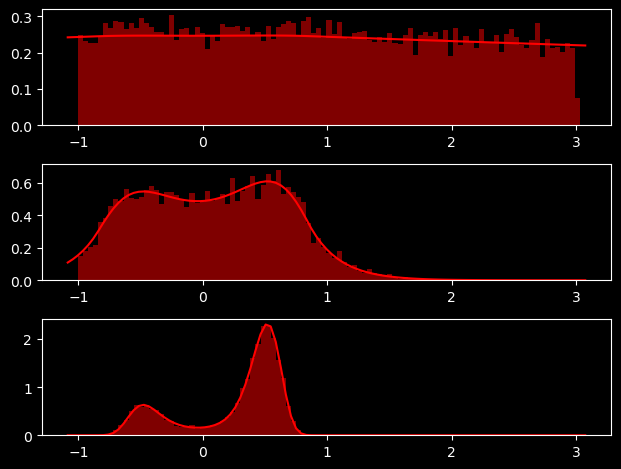

In [27]:
"""Sanity checks: The initial and final distributions should match the Boltzmann distro"""
plt.close()
%matplotlib inline
fig, ax = plt.subplots(len(temperature))
vals = list(temperature.keys()) 


for i in range(len(temperature)):
    ax[i].bar(binned_active_range[1:]-dx/2, heights_init[vals[i]]/(N*dx), width=dx, alpha=0.5, color='r')
    # ax[i].bar(binned_active_range[1:], heights_mid[vals[i]]/(N*dx), width=dx, alpha=0.5, color='orange')
    # ax[i].bar(binned_active_range[1:], heights_mid2[vals[i]]/(N*dx), width=dx, alpha=0.5, color='yellow')
    # ax[i].bar(binned_active_range[1:], heights_fin[vals[i]]/(N*dx), width=dx, alpha=0.5, color='lime')
    # ax[i].plot(binned_active_range[1:], heights_fin[vals[i]]/(N*dx), alpha=0.5, color='lime')
    # ax[i].plot(binned_active_range[1:], heights_mid[vals[i]]/(N*dx), alpha=0.5, color='yellow')
    # # plt.hist(results[-1], bins=50)
    ax[i].plot(binned_active_range, binned_initial_distro[vals[i]]/dx, 'r')
    # ax[i].plot(binned_active_range, binned_final_distro/dx, 'lime')

plt.tight_layout()
plt.show()

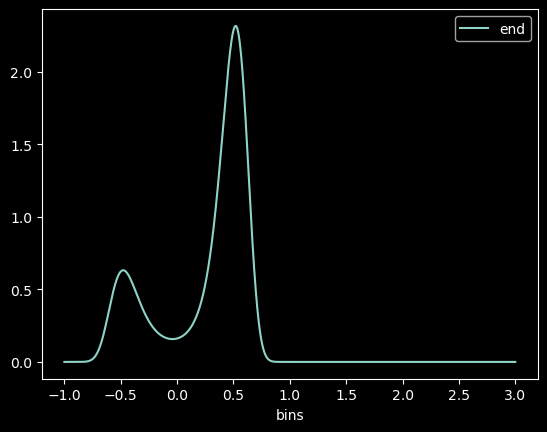

In [25]:
# COMMENT
# # TEMP BLOCK: REMOVE/COMMENT OUT LATER
plt.close()
exp_hist = {}
exp_hist['bins'] = active_range
exp_hist['end'] = np.exp(-U(active_range)/(k_B*T_b))/scipy.integrate.quad(lambda x: np.exp(-U(x)/(k_B*T_b)), x_min, x_max)[0]
exp_hist_df = pd.DataFrame.from_dict(exp_hist)
exp_hist_df.plot(x="bins")
plt.show()
# exp_hist_df.to_csv("./Average energy tests/expected_histograms_2.txt", sep="\t", index=False, float_format="{:.5f}".format)

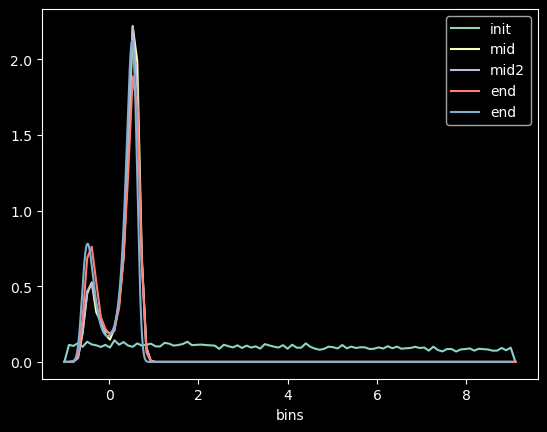

In [52]:
# # # TEMP BLOCK: REMOVE/COMMENT OUT LATER
plt.close()
hist = {}
hist['bins'] = binned_active_range[1:]
hist['init'] = heights_init['h']/(N*dx)
hist['mid'] = heights_mid['h']/(N*dx)
hist['mid2'] = heights_mid2['h']/(N*dx)
hist['end'] = heights_fin['h']/(N*dx)
hist_df = pd.DataFrame.from_dict(hist)
ax = hist_df.plot(x="bins")
exp_hist_df.plot(ax=ax, x="bins")
plt.show()
# hist_df.to_csv("./Average energy tests/Real data/expected_histograms.txt", sep="\t", index=False, float_format="{:.5f}".format)

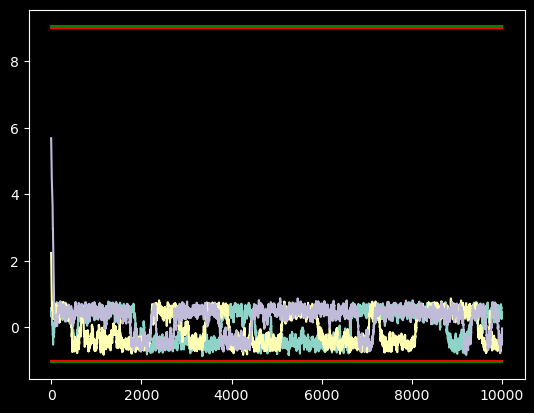

Inefficiency = (1.005376191457464, 1.0541213929775393)


In [53]:
plt.close()
plt.plot(range(int(expt_length//dt)+2), results['h'][np.random.choice(N, 3),:].T)
plt.plot([0,expt_length/dt],[[x_min,x_max], [x_min, x_max]], 'r')
plt.plot([0,expt_length/dt],[[global_min,global_max], [global_min,global_max]], 'g')
plt.show()
print(f"Inefficiency = {inefficiencies}")

In [13]:
binned_final_distro.shape

(101,)

100%|██████████| 3/3 [00:13<00:00,  4.58s/it]


Average noise in distance measurements (N=10000, N_b = 100) = 0.05738
Average noise amplitude in distance measurements (N=10000, N_b = 100) = 0.00732


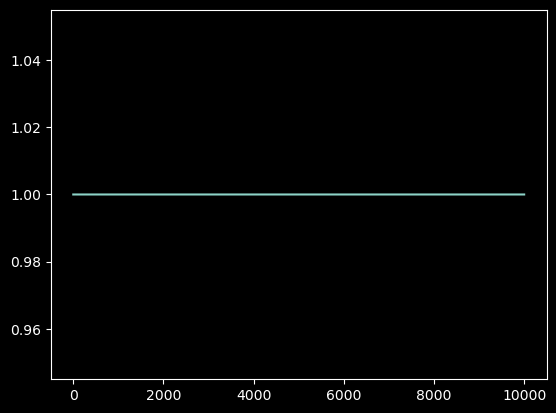

In [ ]:
distances = {}
heights = {}
reshaped_final_distro = np.reshape(binned_final_distro[:-1],(len(binned_final_distro)-1,1)) # We reshape the final distro like this so we can vectorise the L1 distance: this turns it from a size=(n-1) array into a ((n-1),1) size array that you can subtract from a size ((n-1), number_of_timesteps) array without errors.
for T in tqdm(temperature):
    heights[T] = np.apply_along_axis(lambda x: np.histogram(x, bins=binned_active_range-dx/2)[0], axis=0, arr=results[T]) # Subtract off the dx/2 we added earlier so that the histogramming is done properly
    distances[T] = L1(heights[T]/N, reshaped_final_distro, axis=0)
    # Vectorised: about 2x faster than below unvectorised code.

    # Height, Bin = {}, {}
    # for i in tqdm(range(results[T].shape[1])):
    #     Height[T], Bin[T] = np.histogram(results[T][:,i], bins=binned_active_range)
    #     distances[T].append(L1(Height[T]/N, binned_final_distro[:-1]))
plt.close()
plt.plot((heights['h'].sum(axis=0))/N)
print(f"Average noise in distance measurements (N={N}, N_b = {BINS}) = {distances['c'].mean() :.5f}")
print(f"Average noise amplitude in distance measurements (N={N}, N_b = {BINS}) = {distances['c'].std() :.5f}")
plt.show()

In [34]:
heights['h'][:,0].shape

(102,)

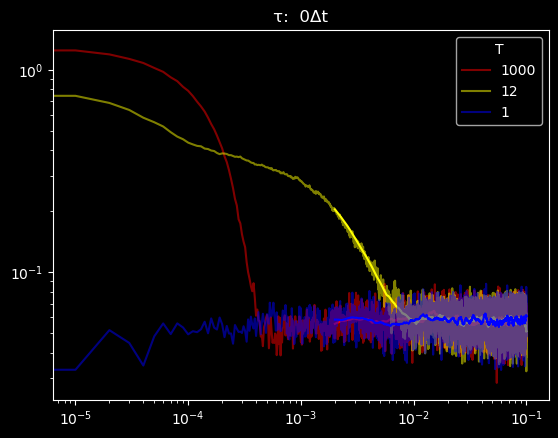

In [ ]:
plt.close()
def moving_average(noisy_data, window=10):
    # Smoothens noisy data. Larger window sizes will mean smoother data, at the cost of less resolution.
    length = len(noisy_data)
    outs = []
    for i in range(length):
        outs.append(np.average(noisy_data[max(i-window//2, 0): min(i+window//2, length)]))
    return outs

fig, ax = plt.subplots()
colours = {'h': 'red', 'w': 'yellow', 'c': 'blue', 'f': 'cyan'}
total_time = round(expt_length/dt) # iterations --- after this point there's only noise
start_time, end_time, window = 200, total_time, 200
for T in temperature:
    ax.loglog(times, distances[T][:-1], color = colours[T], alpha=0.5, label=temperature[T])
    # ax.loglog(range(start_time, end_time), distances[T][start_time:end_time], color = colours[T], alpha=0.3)
    ax.loglog(times[start_time:end_time], moving_average(distances[T], window=window)[start_time:end_time], color = colours[T])
ax.legend(title="T")
plt.title(f"τ: {tau/dt : .0f}Δt")
plt.show()
# export(fig, "./Corrected simulation data/ScriptW potential/Low temperature Mpemba effect", prefixes=f"τ = {tau/dt : .0f}Δt_") # Uncomment to save figure and parameter set

In [14]:
res = np.array([results['h'],results['w'],results['c']])
res

array([[[-0.67751678, -0.62485551, -0.61126213, ...,  0.68220442,
          0.61706782,  0.63384004],
        [ 0.71633716,  0.67410818,  0.65127225, ...,  0.41807377,
          0.39010808,  0.49733202],
        [ 0.14805148,  0.19679944,  0.16810795, ...,  0.68449535,
          0.67511392,  0.51206143],
        ...,
        [-0.80343803, -0.71258993, -0.73259998, ..., -0.0753311 ,
         -0.23485634, -0.2669715 ],
        [ 2.49523495,  2.39934536,  2.19737668, ...,  0.402815  ,
          0.43440254,  0.382524  ],
        [ 1.84862849,  1.76289766,  1.64516616, ..., -0.40591137,
         -0.29722477, -0.27816938]],

       [[ 0.50773508,  0.54291515,  0.49702029, ...,  0.68949734,
          0.62131014,  0.60971288],
        [-0.17271173, -0.28346391, -0.35178391, ...,  0.47161885,
          0.54583542,  0.50154941],
        [-0.31731317, -0.36726747, -0.32289953, ...,  0.48739452,
          0.50481843,  0.58352383],
        ...,
        [-0.25159252, -0.19182683, -0.17478408, ...,  

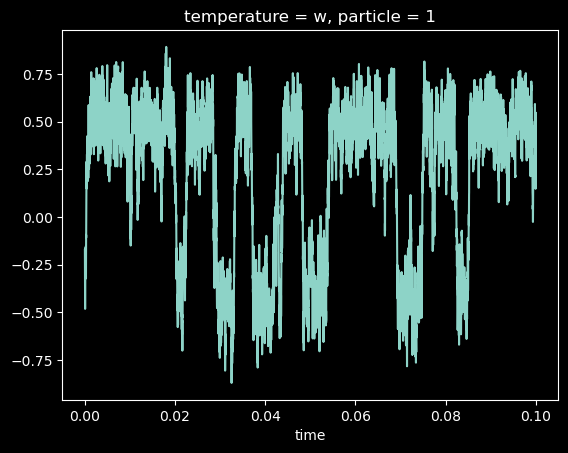

In [38]:
data = xr.DataArray(res, coords=[('temperature', ['h','w','c']), ('particle', np.arange(0,N,1)), ('time', np.arange(0,expt_length+dt,dt))])

data[1,1].plot()

In [28]:
# Average energy computations

energy = {T: U(results[T]) for T in temperature}

In [ ]:
new_times = np.append(times, times[-1]+dt)
average_energy = {'t': new_times}
expected_energy = np.sum(unnormalised_boltzmann(active_range, 1)*U(active_range))/np.sum(unnormalised_boltzmann(active_range, 1))
for T in temperature:
    average_energy[T] = energy[T].mean(axis=0)/expected_energy
output_energy_dataframe = pd.DataFrame.from_dict(average_energy)
output_L1_dataframe = pd.DataFrame(np.array([new_times, distances['h'], distances['w'], distances['c']])).T.rename(columns={0: 't', 1:'L1_h', 2: 'L1_w', 3: 'L1_c'})
# output_energy_dataframe.to_csv("./Average energy tests/Real data/output_energies_simulation.csv", index=False, float_format= "{:.5f}".format, sep="\t")
# output_L1_dataframe.to_csv("./Average energy tests/Real data/output_L1_simulation_alpha3.csv", index=False, float_format= "{:.5f}".format)

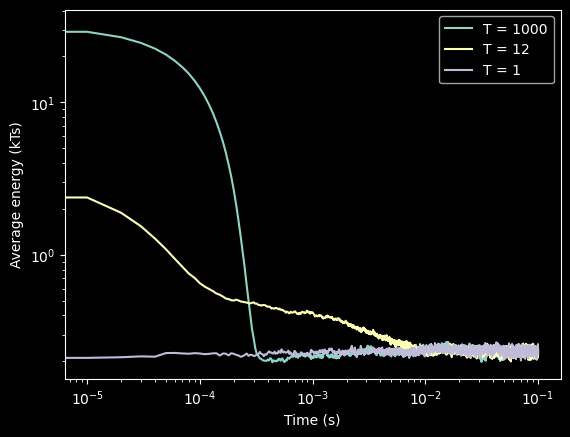

In [29]:
plt.close()

fig, ax = plt.subplots(1)
ax.loglog(times, energy['h'].mean(axis=0)[:-1], label=f"T = {temperature['h']}")
ax.loglog(times, energy['w'].mean(axis=0)[:-1], label=f"T = {temperature['w']}")
ax.loglog(times, energy['c'].mean(axis=0)[:-1], label=f"T = {temperature['c']}")
# ax.loglog([0, expt_length], np.ones(2), label = "Expected energy E_0")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Average energy (kTs)")
ax.legend()
# plt.savefig("./Average energy - N=10_000,alpha=9.0.pdf")
# export(fig, "./Average energy tests/")
plt.show()

In [78]:
energy['h'].mean(axis=0), energy['c'].mean(axis=0)

(array([154.49029485, 151.06877484, 147.63181285, ...,   0.25529578,
          0.23796139,   0.24389776]),
 array([0.21312281, 0.21559436, 0.21933872, ..., 0.25565085, 0.2463099 ,
        0.23171909]))

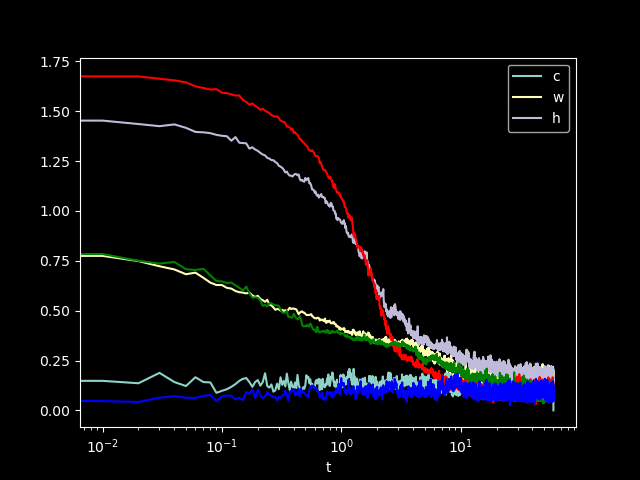

In [65]:
data_alpha9 = pd.read_excel("./Old data/alpha=9.xlsx")
fpe_alpha9 = pd.read_csv("./alpha=9,Th=1000,Tw=12,double_well.csv", names=["t","w","h"])[:6000]
data_alpha9.plot(x="t", logx=True, logy=False)
plt.semilogx(times*1000, distances['h'][:-1], 'r')
# fpe_alpha9.plot(x="t", logx=True)
plt.semilogx(times*1000, distances['w'][:-1], 'g')
plt.semilogx(times*1000, distances['c'][:-1], 'b')

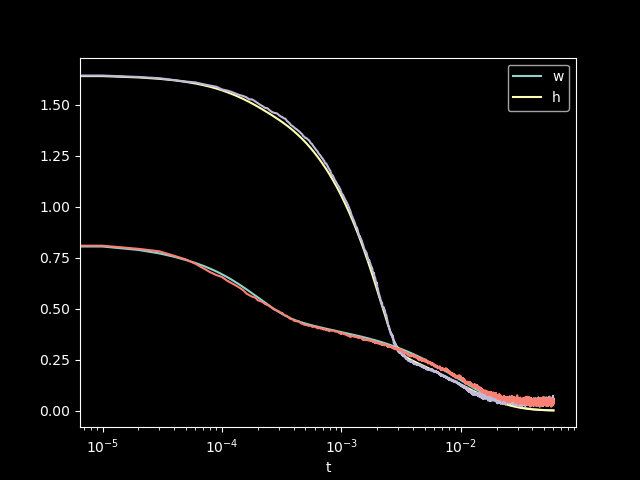

In [41]:
plt.close()
%matplotlib widget
import pandas as pd

data = pd.read_csv("./alpha=9,Th=1000,Tw=12,double_well.csv", names=["t","w","h"])[:6000]
data.plot(x="t", logx=True)
plt.semilogx(times, distances["h"][:-1])
plt.semilogx(times, distances["w"][:-1])
# data = pd.read_csv("./TestData/MpembaW_test1.csv", names=["h", "w"])[:6000]
# data.plot(logx=True, color=['r','g'])

# names = {'c': './alpha3_data/L1_cold.txt',
#          'w': './alpha3_data/L1_warm.txt',
#          'h': './alpha3_data/L1_hot.txt'}
# data = {T: pd.read_table(names[T]) for T in ['c', 'w', 'h']}
# fig, ax = plt.subplots(1)
# for T in ['h']
# for T in ['h', 'w']:
#     data[T].plot(ax=ax, logx=True, color=colours[T], alpha=1)
#     plt.semilogx(distances[T][:], color = colours[T], alpha=0.5)
    
#     # plt.semilogx(range(start_time, end_time), distances[T][start_time:end_time], color = colours[T], alpha=0.3)
#     # plt.semilogx(range(start_time, end_time), moving_average(distances[T], window=window)[start_time:end_time], color = colours[T])
# plt.show()

In [ ]:
plt.close()
potential_data = pd.read_csv("./TestData/MpembaW_test1_potential.csv", names=["x", "c", "w", "h"])
plt.plot(potential_data['x'], potential_data['h'])
plt.plot(binned_active_range, binned_initial_distro['h']/dx)
plt.show()

In [ ]:
plt.close()
key = 'h'

# plt.semilogy(moving_average(distances[key], window=100)[:time_window], color = 'r')
plt.semilogy(distances[key][:time_window], color = 'r', alpha=.7)
# plt.semilogy(moving_average(data[key], window=100)[:time_window], color = 'g')
plt.semilogy(data[key][:time_window], color = 'g', alpha=.7)
plt.show()

|T   | Value     | Exact | Simulated (N=50,000) | Experimental | 
|----|---------|-------------------| --------| -------- |
|$\sim T_\infty$ | $(2^{62} -1)T_b$ | 1.3204462627276485 | NA | NA |
|$T_h$ | $1000T_b$ | 1.2032851931580588 | 1.2000941778266312 | 1.2472471 |
|$T_w$ | $12T_b$   | 0.7948224781813559 | 0.7975410636077775 | 0.7587586 |
|$T_c$ | $T_b$     | 0.0               | 0.11996244969059888 | 0.15615606 |

**For $\alpha=3$, L1 distances**

Noise measurements for Mpemba effect with standard double well potential --- $F_{\max} = 50$, $x_{\min} = -0.5$, $\alpha = 3$, $T_h = 100$, $T_w = 10$. 

| $N$ | $N_b$ | $\sigma_{\mathcal D}$ |
|-----|-------|-----------------------|
| 100 | 100   | 0.46304               |
| 1,000| 100   | 0.17751               |
|10,000| 100   | 0.12181               |
|10,000| 400   | 0.09438               |
|10,000| 900   | 0.13553               |
|100,000| 100   | 0.11575               |

100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


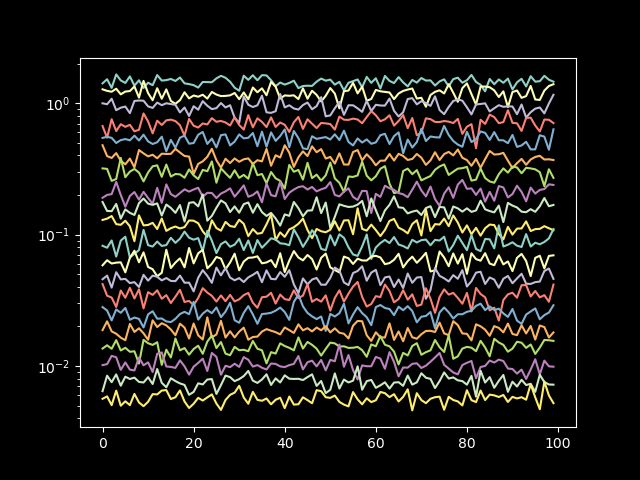

No such comm: 7b2acca25f8a46b09a32b544256c8cca


In [231]:
plt.close()
boltzmann = lambda x, T: unnormalised_boltzmann(x, T)/np.sum(unnormalised_boltzmann(x,T))
num_histograms = 100
N_vals = np.logspace(1,6,20)
noise_floor = []
noise_floor_sigma = []
expected_pdf = boltzmann(binned_active_range[:-1], temperature['c'])
for N_0 in tqdm(N_vals):
    x_c = np.random.choice(binned_active_range, (int(N_0), num_histograms), p=binned_final_distro)
    heights_c = np.apply_along_axis(lambda x: np.histogram(x, bins=binned_active_range)[0], axis=0, arr=x_c)
    distances_c = L1(heights_c/int(N_0), reshaped_final_distro, axis=0)
    plt.semilogy(distances_c)
    noise_floor.append(distances_c.mean())
    noise_floor_sigma.append(distances_c.std())
N_vals = np.array(N_vals)
plt.show()

In [232]:
# num_histograms = 100
# N_vals = np.logspace(1,6,20)
# noise_floor = []
# noise_floor_sigma = []
# expected_pdf = boltzmann(binned_active_range[:-1], temperature['h'])
# for N in tqdm(N_vals):
#     x_c = boltzmann_samples((int(N), num_histograms), T=temperature['h'])
#     heights_c = np.apply_along_axis(lambda x: np.histogram(x, bins=binned_active_range)[0], axis=0, arr=x_c)
#     distances_c = L1(heights_c/int(N), reshaped_final_distro, axis=0)
#     plt.semilogy(distances_c)
#     noise_floor.append(distances_c.mean())
#     noise_floor_sigma.append(distances_c.std())
# N_vals = np.array(N_vals)

NameError: name 'N_vals' is not defined

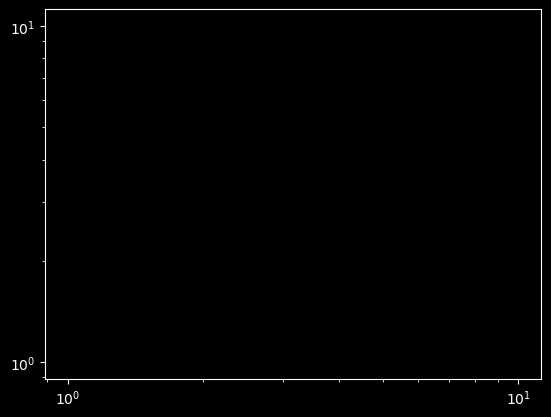

In [28]:
plt.close()
plt.loglog()
plt.scatter(N_vals, noise_floor, marker="x", label = "Average")
plt.scatter(N_vals, noise_floor_sigma, marker=".", label = "STD")
plt.scatter((N,), (distances['c'].mean(),), marker = "*", label = f"Simulation results (N={N})", color="red")

params_sigma, resids = scipy.optimize.curve_fit(lambda x, a: a/x**0.5, N_vals, noise_floor_sigma)
params_sqrt, _ = scipy.optimize.curve_fit(lambda x, a: a/x**0.5, N_vals, noise_floor)
plt.loglog(N_vals, params_sigma[0]/N_vals**0.5)
plt.loglog(N_vals, params_sqrt[0]/N_vals**0.5)
plt.legend()
plt.show()

In [ ]:
# Tests for sampling function

np.random.choice(active_range, N=N)

In [ ]:
T = 'h'
# Height, Bin = {}, {}
# Height[T], Bin[T] = np.histogram(results[T][:,0], bins=binned_active_range)
# L1(binned_initial_distro[T], binned_initial_distro['c'])#, data[T]['L1_cold'][0]
# L1(normalised_distro[T], normalised_distro['c'])*(x_max-x_min)/10000

# scipy.integrate.quad(lambda x:np.abs(boltzmann(x, temperature['h'])-boltzmann(x, temperature['c'])), x_min, x_max)

In [ ]:
boltzmann = lambda x, T: np.exp(-U(x)/(k_B*T))/scipy.integrate.quad(lambda y: np.exp(-U(y)/(k_B*T)), x_min, x_max)[0]
L1(boltzmann(active_range, temperature['h']), boltzmann(active_range, temperature['c']))*(active_range[1]-active_range[0])

In [ ]:
temps = 2**np.arange(0,63,1, dtype=np.float64)
distros = np.array([unnormalised_boltzmann(binned_active_range, temp) for temp in temps])
new = np.divide(distros.T, np.sum(distros, axis=1)).T

Distances = np.array([L1(binned_final_distro[:], new[T, :]) for T in range(len(temps))])
plt.semilogx(temps, Distances)
temps[-1], Distances[-1]

In [40]:
# ANIMATION: UNCOMMENT THE LINES BELOW TO ANIMATE THE VIDEOS

# fig = plt.figure()
# ims = []
T = 'h'

new_binned_active_range = np.linspace(x_min, x_max, 200)
new_unnormalised_initial_distro = unnormalised_boltzmann(new_binned_active_range, temperature[T])
new_binned_initial_distro = new_unnormalised_initial_distro/np.sum(new_unnormalised_initial_distro)
new_unnormalised_final_distro = unnormalised_boltzmann(new_binned_active_range, temperature['c'])
new_binned_final_distro = new_unnormalised_final_distro/np.sum(new_unnormalised_final_distro)

fig, ax = plt.subplots()
heights, bins = np.histogram(results[T][:,0], bins=new_binned_active_range)
patches = ax.bar(bins[:-1], heights/N, width=bins[1]-bins[0])
ax_height = np.max(new_binned_final_distro + 0.02)
ax.set_ylim(0,ax_height)
temperature_function= lambda t: (temperature[T]-T_b)*np.exp(-t/tau)+T_b

set_const_height = True
set_moving_height = False
plot_analytic_solution = False

# animated_frames = [i for i in range(20)] + [i for i in range(20,60, 2)] + [i for i in range(60,360, 5)] + [i for i in range(360,3960, 10)] + [i for i in range(3960,30000, 100)]
num_animated_frames = 500 # Keep it small for efficient rendering
exponential_frame_func = lambda x, x_0: (expt_length/dt)*(np.exp(x/x_0)-1)/(np.exp(num_animated_frames/x_0)-1)
animated_frames = np.rint(exponential_frame_func(np.arange(0,num_animated_frames+1, 1), 100)).astype('int')
# Time in the video will be on a log scale, primarily for rendering efficiency


def analytic_solution(x,t):
    unnormalised_soln = np.exp(-binned_active_range**2/(4*D*t))
    return unnormalised_soln/np.sum(unnormalised_soln)

ax.set_xlim((-1,3))
ax.set_xlabel("x")
ax.set_ylabel("p(x,t)")
ax.plot(new_binned_active_range, new_binned_initial_distro, 'r')
ax.plot(new_binned_active_range, new_binned_final_distro, 'g')
# Update function for the animation
def update(frame_number):
    # Get the data for the current frame
    # ax.clear()
    heights, bins = np.histogram(results[T][:,frame_number], bins=new_binned_active_range)    
    # Update the histogram data
    for i in range(len(patches)):
        patches[i].set_height(heights[i]/N)#, width=bins[1]-bins[0], color='y', alpha=0.7)
    ax.set_title(f"t = {frame_number*dt*1e6 : .0f} μs; E/E_0 = {U(results[T][:,frame_number]).mean()/expected_energy : .3f}")
    if set_moving_height:
        if frame_number % 100 == 0:
            ax.set_ylim(0,ax_height)
    elif set_const_height:
        ax.set_ylim(0,ax_height)
    if plot_analytic_solution:
        t = frame_number*dt
        if t != 0:
            ax.plot(binned_active_range, analytic_solution(binned_active_range, t), 'y')
    # for i in range(len(bins)):
    #     patches[i].set_height(heights[i])
    return patches

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=animated_frames, interval=10, blit=True, cache_frame_data=True)
plt.close()

HTML(ani.to_html5_video())

In [27]:
results['h'].shape

(10000, 10001)

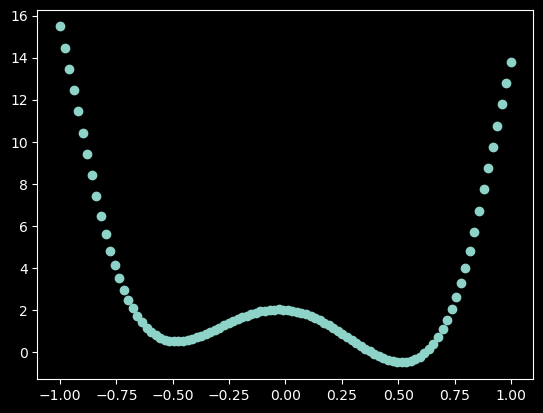

In [30]:
# points = plt.scatter(binned_active_domain, U(binned_active_domain))

In [104]:
# ANIMATION: UNCOMMENT THE LINES BELOW TO ANIMATE THE VIDEOS

# fig = plt.figure()
# ims = []
T = 'h'

new_binned_active_range = np.linspace(x_min, x_max, 200)
# new_unnormalised_initial_distro = unnormalised_boltzmann(new_binned_active_range, temperature[T])
# new_binned_initial_distro = new_unnormalised_initial_distro/np.sum(new_unnormalised_initial_distro)
# new_unnormalised_final_distro = unnormalised_boltzmann(new_binned_active_range, temperature['c'])
# new_binned_final_distro = new_unnormalised_final_distro/np.sum(new_unnormalised_final_distro)

fig, ax = plt.subplots()
# heights, bins = np.histogram(results[T][:,0], bins=new_binned_active_range)
# patches = ax.bar(bins[:-1], heights/N, width=bins[1]-bins[0])
# ax_height = np.max(new_binned_final_distro + 0.02)
# ax.set_ylim(0,ax_height)
# temperature_function= lambda t: (temperature[T]-T_b)*np.exp(-t/tau)+T_b

# set_const_height = True
# set_moving_height = False
# plot_analytic_solution = False

# animated_frames = [i for i in range(20)] + [i for i in range(20,60, 2)] + [i for i in range(60,360, 5)] + [i for i in range(360,3960, 10)] + [i for i in range(3960,30000, 100)]
num_animated_frames = 500 # Keep it small for efficient rendering
exponential_frame_func = lambda x, x_0: (expt_length/dt)*(np.exp(x/x_0)-1)/(np.exp(num_animated_frames/x_0)-1)
animated_frames = np.rint(exponential_frame_func(np.arange(0,num_animated_frames+1, 1), 100)).astype('int')
# animated_frames = np.rint(np.arange(0,num_animated_frames+1, 1)*1).astype('int')
# Time in the video will be on a log scale, primarily for rendering efficiency


def analytic_solution(x,t):
    unnormalised_soln = np.exp(-binned_active_range**2/(4*D*t))
    return unnormalised_soln/np.sum(unnormalised_soln)

# ax[0].set_xlim((-1,3))
ax.set_xlabel("x")
ax.set_ylabel("U(x)")
# ax.plot(new_binned_active_range, new_binned_initial_distro, 'r')
# ax.plot(new_binned_active_range, new_binned_final_distro, 'g')
ax.plot(active_range, U(active_range)-1, 'lime', alpha=0.5)
# ax[1].plot(active_range, U(active_range)-1, 'lime')
# patches = ax[2].bar(["Hot", "Warm"], [distances['h'][0], distances['w'][0]])
# Update function for the animation
particles = results['h'][(np.random.choice(range(1,N+1), 100)), :]
# particles_w = results['w'][(np.random.choice(range(1,N+1), 100)), :]
points = ax.scatter(particles[:,0], U(particles[:,0]), marker=".")
# points_w = ax[1].scatter(particles_w[:,0], U(particles_w[:,0]), marker=".")
fig.suptitle(f"t = 0 μs")
# plt.tight_layout()

def update(frame_number):
    # Get the data for the current frame
    # ax.clear()
    # heights, bins = np.histogram(results[T][:,frame_number], bins=new_binned_active_range)    
    # Update the histogram data
    # for i in range(len(patches)):
    #     patches[i].set_height(heights[i]/N)#, width=bins[1]-bins[0], color='y', alpha=0.7)
    fig.suptitle(f"t = {frame_number*dt*1e6 : .0f} μs")
    # ax[0].set_title(f"L1 distance = {distances['h'][frame_number] : .4f}")
    # ax[1].set_title(f"L1 distance = {distances['w'][frame_number] : .4f}")
    # if set_moving_height:
    #     if frame_number % 100 == 0:
    #         ax.set_ylim(0,ax_height)
    # elif set_const_height:
    #     ax.set_ylim(0,ax_height)
    # if plot_analytic_solution:
    #     t = frame_number*dt
    #     if t != 0:
    #         ax.plot(binned_active_range, analytic_solution(binned_active_range, t), 'y')
    # # for i in range(len(bins)):
    # #     patches[i].set_height(heights[i])
    # return patches
    points.set_offsets(np.array([particles[:,frame_number], U(particles[:,frame_number])]).T)
    # points_w.set_offsets(np.array([particles_w[:,frame_number], U(particles_w[:,frame_number])]).T)
    # for i in range(len(patches)):
    #     patches[i].set_height(distances[['h','w'][i]][frame_number])
    return points,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=animated_frames, interval=10, blit=True, cache_frame_data=True)
plt.close()

HTML(ani.to_html5_video())

In [ ]:
# ANIMATION: UNCOMMENT THE LINES BELOW TO ANIMATE THE VIDEOS

# fig = plt.figure()
# ims = []
T = 'h'

new_binned_active_range = np.linspace(x_min, x_max, 200)
# new_unnormalised_initial_distro = unnormalised_boltzmann(new_binned_active_range, temperature[T])
# new_binned_initial_distro = new_unnormalised_initial_distro/np.sum(new_unnormalised_initial_distro)
# new_unnormalised_final_distro = unnormalised_boltzmann(new_binned_active_range, temperature['c'])
# new_binned_final_distro = new_unnormalised_final_distro/np.sum(new_unnormalised_final_distro)

fig, ax = plt.subplots(3)
# heights, bins = np.histogram(results[T][:,0], bins=new_binned_active_range)
# patches = ax.bar(bins[:-1], heights/N, width=bins[1]-bins[0])
# ax_height = np.max(new_binned_final_distro + 0.02)
# ax.set_ylim(0,ax_height)
# temperature_function= lambda t: (temperature[T]-T_b)*np.exp(-t/tau)+T_b

# set_const_height = True
# set_moving_height = False
# plot_analytic_solution = False

# animated_frames = [i for i in range(20)] + [i for i in range(20,60, 2)] + [i for i in range(60,360, 5)] + [i for i in range(360,3960, 10)] + [i for i in range(3960,30000, 100)]
num_animated_frames = 500 # Keep it small for efficient rendering
exponential_frame_func = lambda x, x_0: (expt_length/dt)*(np.exp(x/x_0)-1)/(np.exp(num_animated_frames/x_0)-1)
animated_frames = np.rint(exponential_frame_func(np.arange(0,num_animated_frames+1, 1), 100)).astype('int')
# animated_frames = np.rint(np.arange(0,num_animated_frames+1, 1)*1).astype('int')
# Time in the video will be on a log scale, primarily for rendering efficiency


def analytic_solution(x,t):
    unnormalised_soln = np.exp(-binned_active_range**2/(4*D*t))
    return unnormalised_soln/np.sum(unnormalised_soln)

# ax[0].set_xlim((-1,3))
ax[0].set_xlabel("x")
ax[0].set_ylabel("U(x)")
# ax.plot(new_binned_active_range, new_binned_initial_distro, 'r')
# ax.plot(new_binned_active_range, new_binned_final_distro, 'g')
ax[0].plot(active_range, U(active_range)-1, 'lime')
ax[1].plot(active_range, U(active_range)-1, 'lime')
patches = ax[2].bar(["Hot", "Warm"], [distances['h'][0], distances['w'][0]])
# Update function for the animation
particles = results['h'][(np.random.choice(range(1,N+1), 100)), :]
particles_w = results['w'][(np.random.choice(range(1,N+1), 100)), :]
points = ax[0].scatter(particles[:,0], U(particles[:,0]), marker=".")
points_w = ax[1].scatter(particles_w[:,0], U(particles_w[:,0]), marker=".")
fig.suptitle(f"t = 0 μs")
plt.tight_layout()

def update(frame_number):
    # Get the data for the current frame
    # ax.clear()
    # heights, bins = np.histogram(results[T][:,frame_number], bins=new_binned_active_range)    
    # Update the histogram data
    # for i in range(len(patches)):
    #     patches[i].set_height(heights[i]/N)#, width=bins[1]-bins[0], color='y', alpha=0.7)
    fig.suptitle(f"t = {frame_number*dt*1e6 : .0f} μs")
    # ax[0].set_title(f"L1 distance = {distances['h'][frame_number] : .4f}")
    # ax[1].set_title(f"L1 distance = {distances['w'][frame_number] : .4f}")
    # if set_moving_height:
    #     if frame_number % 100 == 0:
    #         ax.set_ylim(0,ax_height)
    # elif set_const_height:
    #     ax.set_ylim(0,ax_height)
    # if plot_analytic_solution:
    #     t = frame_number*dt
    #     if t != 0:
    #         ax.plot(binned_active_range, analytic_solution(binned_active_range, t), 'y')
    # # for i in range(len(bins)):
    # #     patches[i].set_height(heights[i])
    # return patches
    points.set_offsets(np.array([particles[:,frame_number], U(particles[:,frame_number])]).T)
    points_w.set_offsets(np.array([particles_w[:,frame_number], U(particles_w[:,frame_number])]).T)
    for i in range(len(patches)):
        patches[i].set_height(distances[['h','w'][i]][frame_number])
    return points,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=animated_frames, interval=10, blit=True, cache_frame_data=True)
plt.close()

HTML(ani.to_html5_video())

In [80]:
['h','w'][1]

'w'